In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
from Classification.cnn1D_model_with_freq import VibrationDataset, CNN1D_DS, FrequencyDomainCNN
from Classification.cnn1D_model_with_freq import train_and_evaluate, train_and_evaluate_with_kfold
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft
from utils.xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance
from sklearn.model_selection import GroupKFold
from collections import Counter

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load dataset, Stratify based on Lable and Operation, so that the train, test, val sets have appropriate amount of each group

data_directory = "../data/final/new_selection/normalized_windowed_downsampled_data"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/20] - Train Loss: 0.4658, Train Acc: 0.7684 - Val Loss: 0.2104, Val Acc: 0.9413 
Epoch [2/20] - Train Loss: 0.1434, Train Acc: 0.9556 - Val Loss: 0.0822, Val Acc: 0.9751 
Epoch [3/20] - Train Loss: 0.0667, Train Acc: 0.9792 - Val Loss: 0.0406, Val Acc: 0.9893 
Epoch [4/20] - Train Loss: 0.0436, Train Acc: 0.9884 - Val Loss: 0.1111, Val Acc: 0.9600 
Epoch [5/20] - Train Loss: 0.0537, Train Acc: 0.9808 - Val Loss: 0.0279, Val Acc: 0.9911 
Epoch [6/20] - Train Loss: 0.0263, Train Acc: 0.9931 - Val Loss: 0.0233, Val Acc: 0.9911 
Epoch [7/20] - Train Loss: 0.0226, Train Acc: 0.9930 - Val Loss: 0.0745, Val Acc: 0.9671 
Epoch [8/20] - Train Loss: 0.0260, Train Acc: 0.9926 - Val Loss: 0.0220, Val Acc: 0.9920 
Epoch [9/20] - Train Loss: 0.0278, Train Acc: 0.9907 - Val Loss: 0.0161, Val Acc: 0.9938 
Epoch [10/20] - Train Loss: 0.0200, Train Acc: 0.9939 - Val Loss: 0.0226, Val Acc: 0.9929 
Epoch [11/20] - Train Loss: 0.0185, Train Acc: 0.9939 - Val Loss: 0.0444, Val Ac

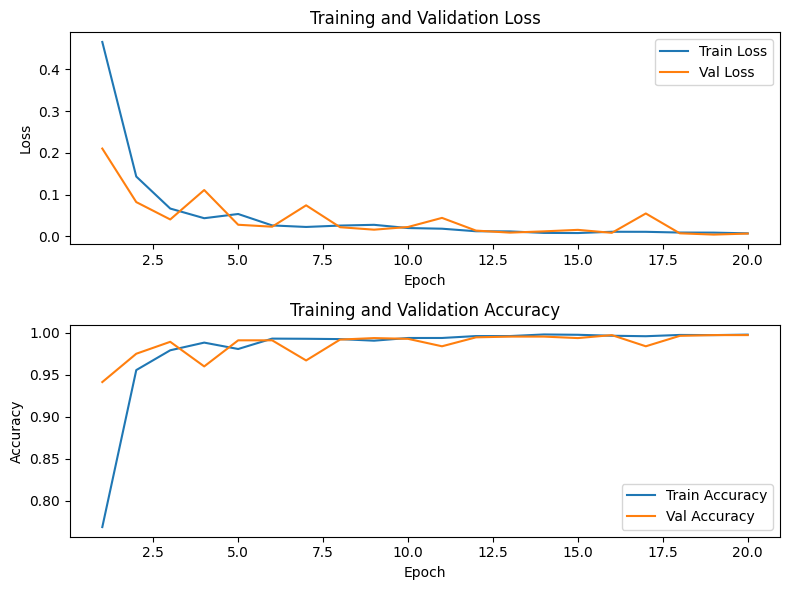

In [6]:
freq_model = train_and_evaluate(train_loader, val_loader, test_loader, EralyStopping=True)


In [7]:
# Save the trained model
torch.save(freq_model.state_dict(), "../cnn1d_freq.ckpt")
print("✅ Model saved to cnn1d_freq.ckpt")
freq_model.to(device)
freq_model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")
print(f"✅ Model is structured as  \n {freq_model}")


✅ Model saved to cnn1d_freq.ckpt
✅ Model loaded and ready for explanations
✅ Model is structured as  
 FrequencyDomainCNN(
  (time_cnn): CNN1D_DS(
    (feature_extractor): Sequential(
      (0): Conv1d(3, 16, kernel_size=(9,), stride=(1,))
      (1): GroupNorm(4, 16, eps=1e-05, affine=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
      (5): GroupNorm(4, 32, eps=1e-05, affine=True)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (9): GroupNorm(4, 64, eps=1e-05, affine=True)
      (10): ReLU()
      (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): AdaptiveAvgPool1d(output_size=1)
    )
    (classifier): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Drop

### Explain the Model

#### choose a good sample

In [8]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(test_loader))

# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(freq_model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}, True_label:{label}")
print(sample, sample.shape)


Random Index: 44, Predicted_label:0, True_label:0
tensor([[-0.0292,  0.0421, -0.0398,  ..., -0.0029, -0.3294,  0.3217],
        [ 0.0746, -0.1980,  0.1954,  ...,  0.4167, -0.2443, -0.1246],
        [ 0.1464,  0.0050, -0.1478,  ..., -0.4492,  0.3497,  0.0996]],
       device='cuda:0') torch.Size([3, 2000])


#### DFT-LRP implementation

In [9]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=freq_model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


Min relevance: -0.04842900112271309, Max relevance: 0.04036867618560791
 Maximum Absolute Attribution in Axis 0: 0.044466592371463776
 Maximum Absolute Attribution in Axis 1: 0.007701072841882706
 Maximum Absolute Attribution in Axis 2: 0.04842900112271309


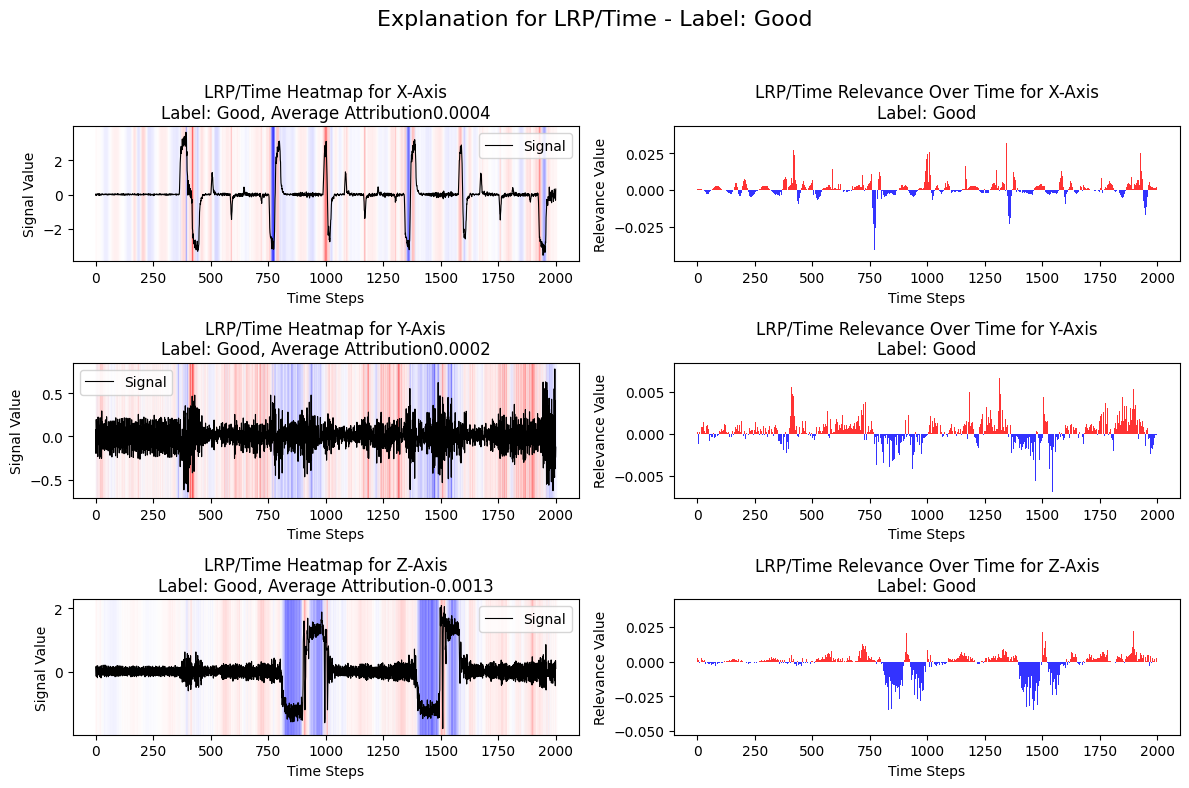

In [10]:
# LRP visualization with mutual visualization function
print(f"Min relevance: {np.min(relevance_time)}, Max relevance: {np.max(relevance_time)}")
visualize_with_label_attribution(sample, relevance_time, label, "LRP/Time")


In [11]:
""# Global Attribution over frequency with LRP
summary_lrp_freq = summarize_attributions(relevance_freq)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_freq = []
for axis, values in summary_lrp_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_freq.append(row)

# Create the DataFrame
df_summary_lrp_freq = pd.DataFrame(data_lrp_freq)

# Display the DataFrame as a table
print(df_summary_lrp_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             492                959.438033   
1  Axis 1             508                  8.964473   
2  Axis 2             522                 22.445252   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    1.950077             509               -958.287034   
1                    0.017647             493                 -8.413667   
2                    0.042999             479                -25.127121   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -1.882686                     1.150999   
1                   -0.017066                     0.550806   
2                   -0.052457                    -2.681869   

   Average Relevance (Pos + Neg)  
0                       0.001150  
1                       0.000550  
2                      -0.002679  


In [12]:
""# Global Attribution over frequency with LRP
summary_lrp_t = summarize_attributions(relevance_time)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t = []
for axis, values in summary_lrp_t.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t.append(row)

# Create the DataFrame
df_summary_lrp_t = pd.DataFrame(data_lrp_t)

# Display the DataFrame as a table
print(df_summary_lrp_t)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1083                  3.853187   
1  Axis 1            1196                  1.259793   
2  Axis 2            1156                  3.479597   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.003558             917                 -2.982238   
1                    0.001053             804                 -0.769360   
2                    0.003010             844                 -6.168587   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003252                     0.870949   
1                   -0.000957                     0.490433   
2                   -0.007309                    -2.688991   

   Average Relevance (Pos + Neg)  
0                       0.000435  
1                       0.000245  
2                      -0.001344  


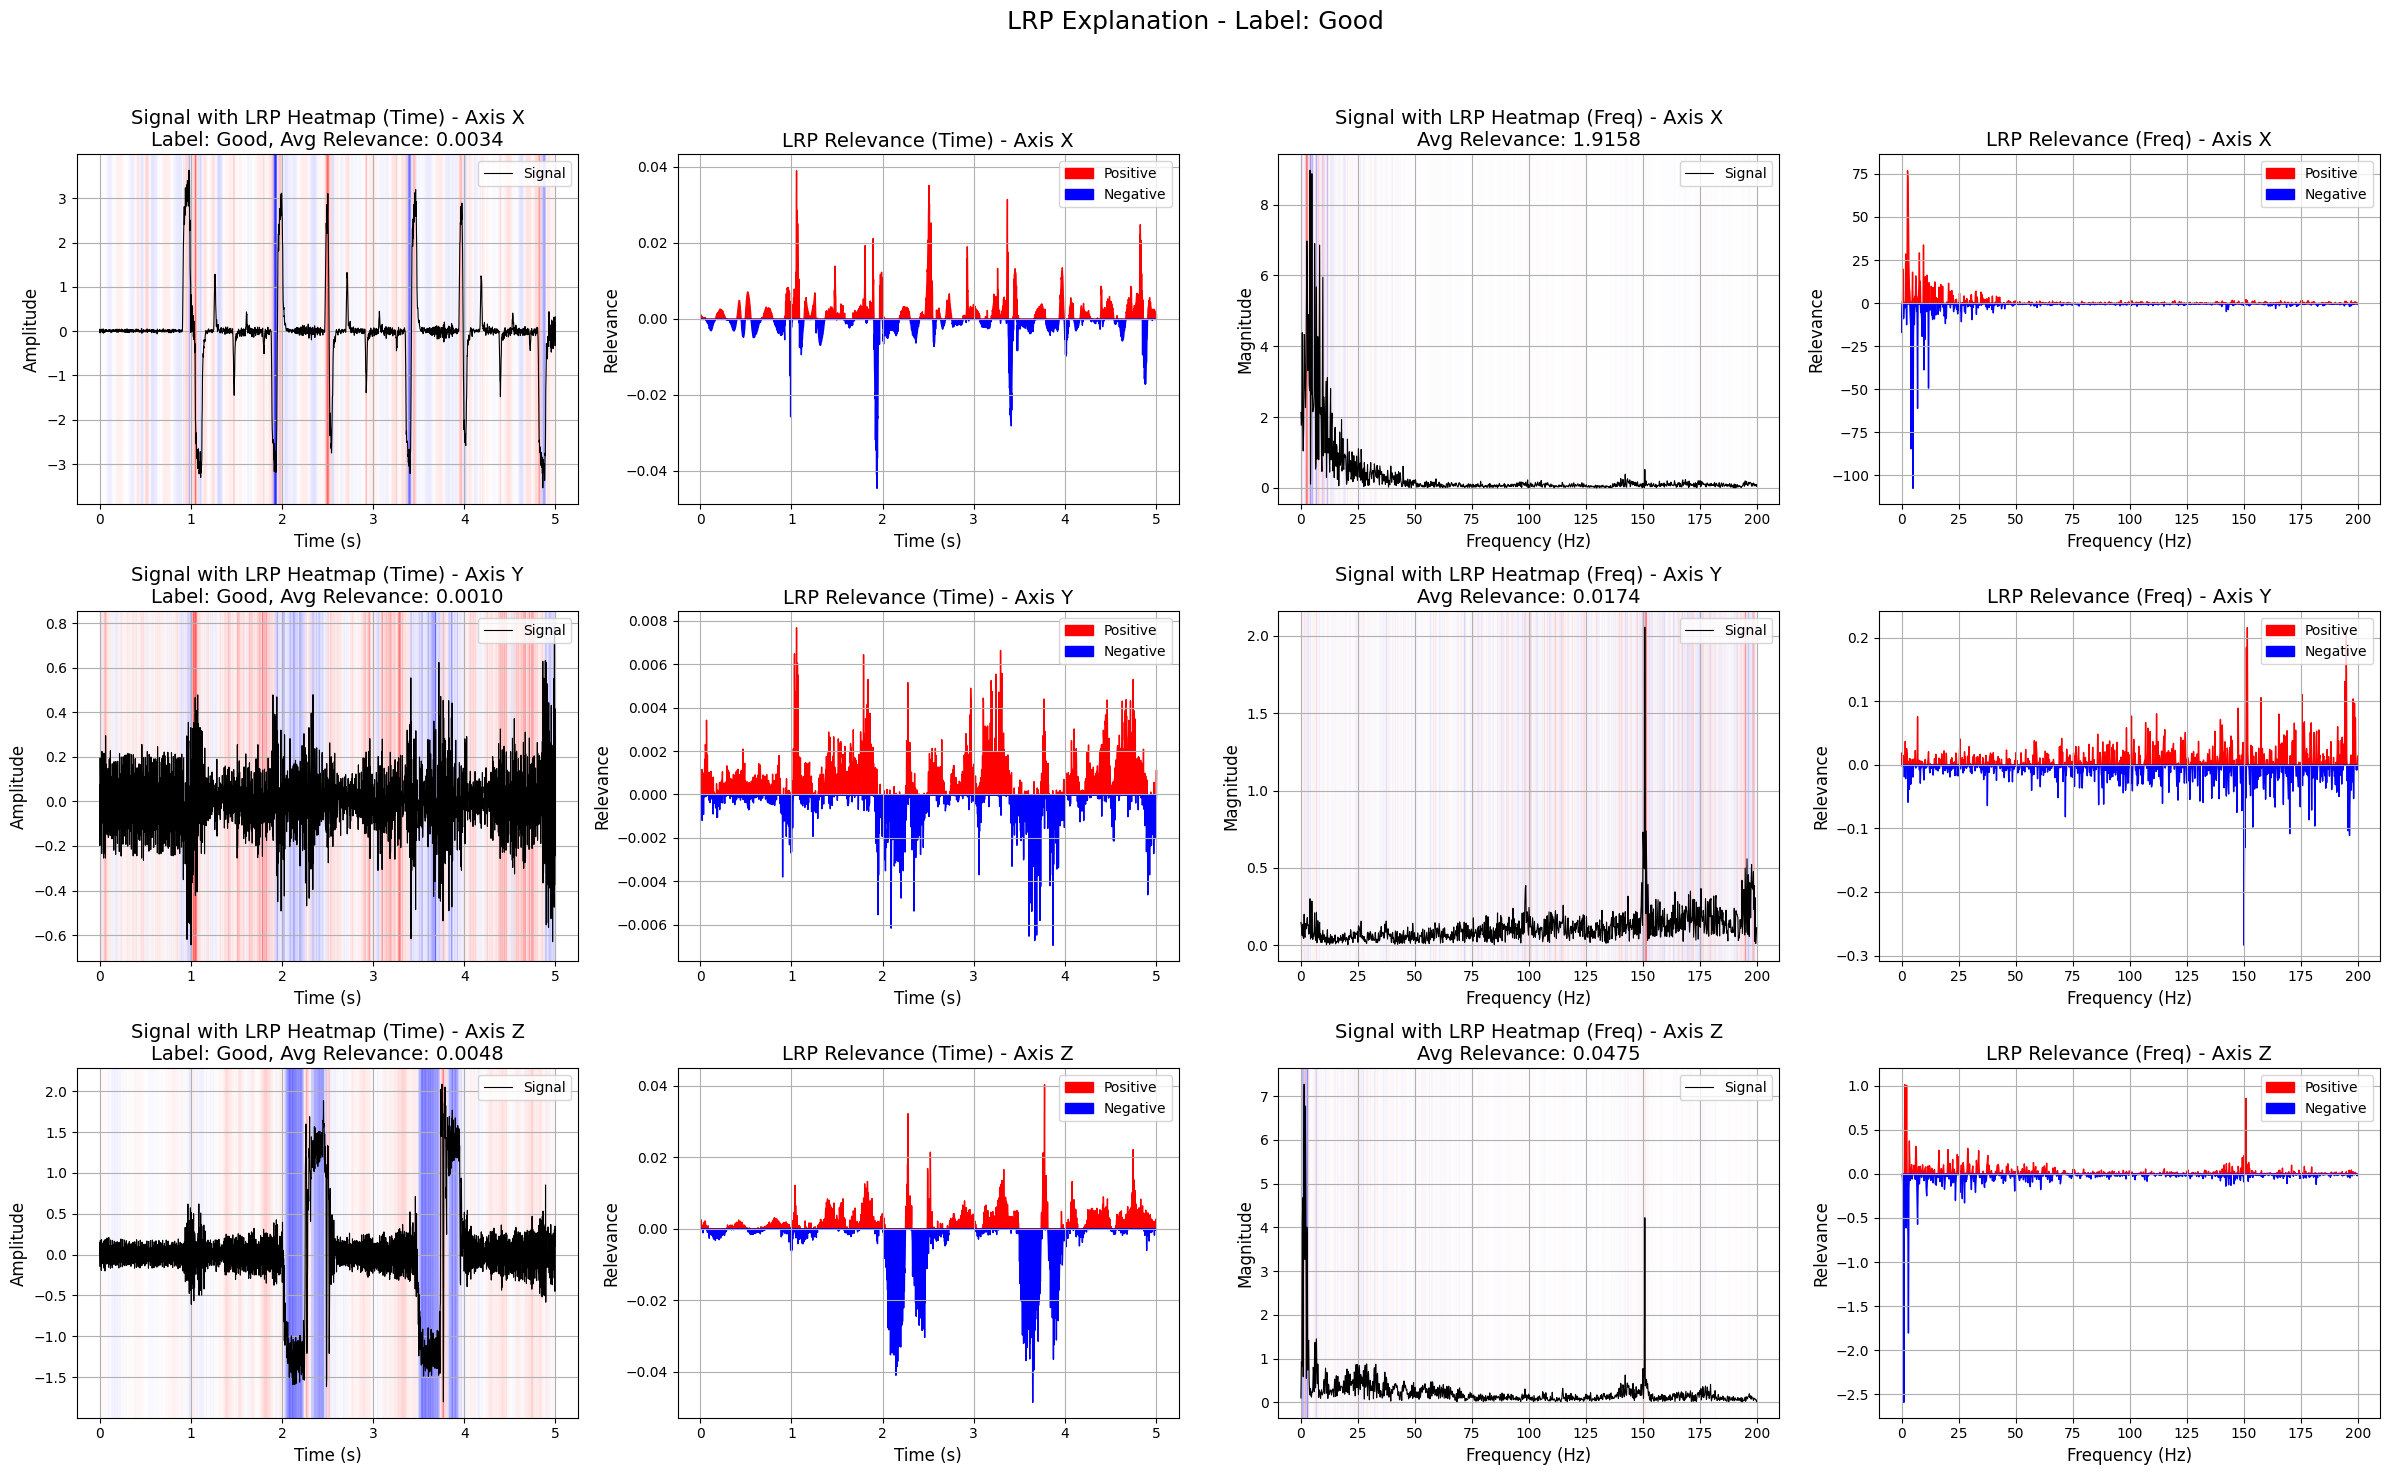

In [13]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [14]:
# LRP visualization with common visualization function
 # write something similar to the common visualization for the frequency, so the relevance are colored over fft/dft signals
# in compute_dft_lrp_relevance why freqs are calculated by fft not dft?

#### FFT-LRP implementation?

Min relevance: -0.032294873148202896, Max relevance: 0.03587214648723602
 Maximum Absolute Attribution in Axis 0: 0.03587214648723602
 Maximum Absolute Attribution in Axis 1: 0.003389117307960987
 Maximum Absolute Attribution in Axis 2: 0.018198462203145027


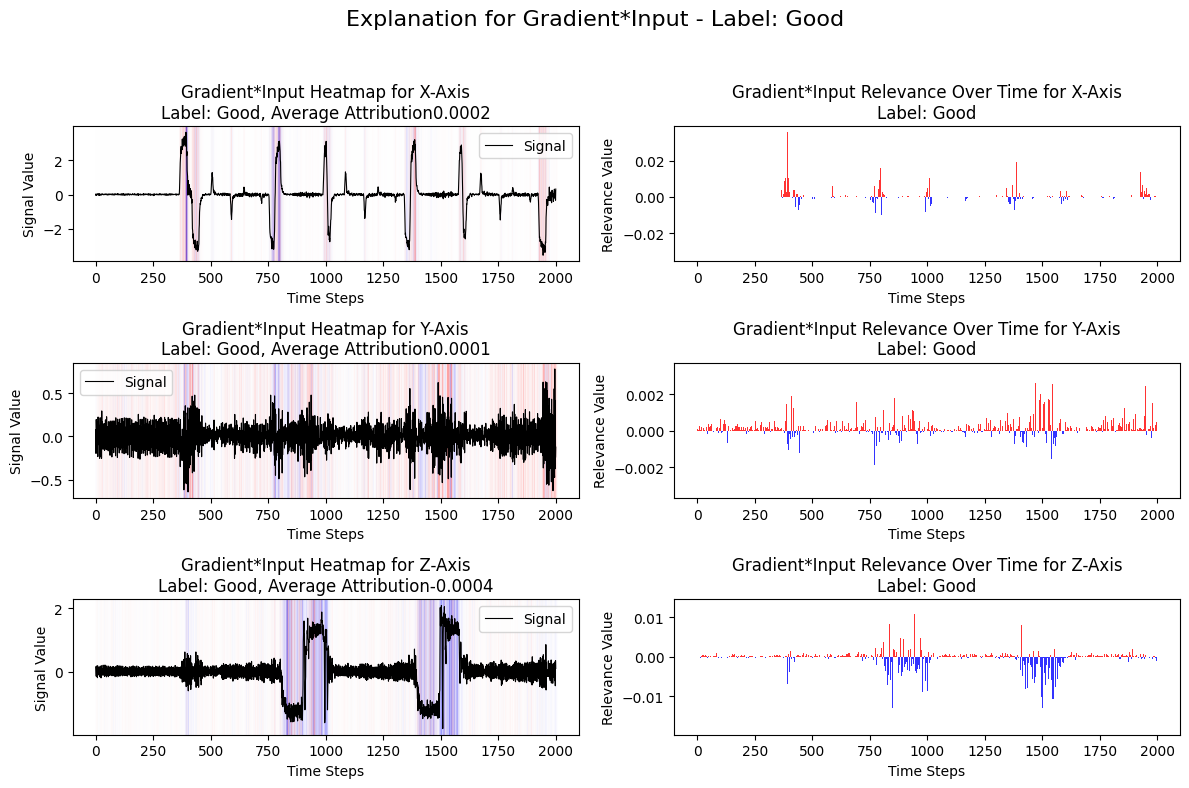

In [15]:
# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(freq_model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [16]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1115                  1.107287   
1  Axis 1            1261                  0.361499   
2  Axis 2            1075                  0.664203   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000993             885                 -0.663200   
1                    0.000287             739                 -0.151248   
2                    0.000618             925                 -1.369130   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000749                     0.444088   
1                   -0.000205                     0.210251   
2                   -0.001480                    -0.704926   

   Average Relevance (Pos + Neg)  
0                       0.000222  
1                       0.000105  
2                      -0.000352  


Min relevance: -0.03673070669174194, Max relevance: 0.05731914937496185
 Maximum Absolute Attribution in Axis 0: 0.05731914937496185
 Maximum Absolute Attribution in Axis 1: 0.01871519163250923
 Maximum Absolute Attribution in Axis 2: 0.03673070669174194


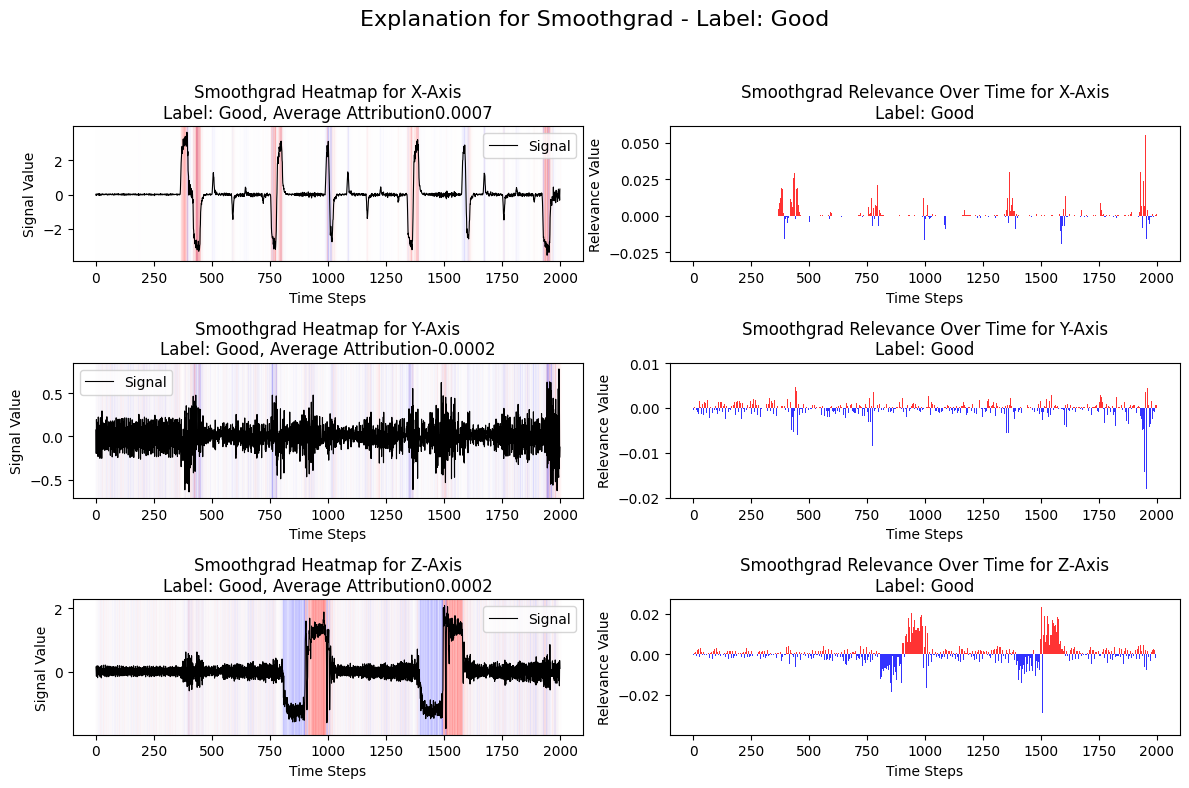

In [17]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(freq_model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.02299785614013672, Max relevance: 0.040523529052734375
 Maximum Absolute Attribution in Axis 0: 0.040523529052734375
 Maximum Absolute Attribution in Axis 1: 0.0033884048461914062
 Maximum Absolute Attribution in Axis 2: 0.012183666229248047


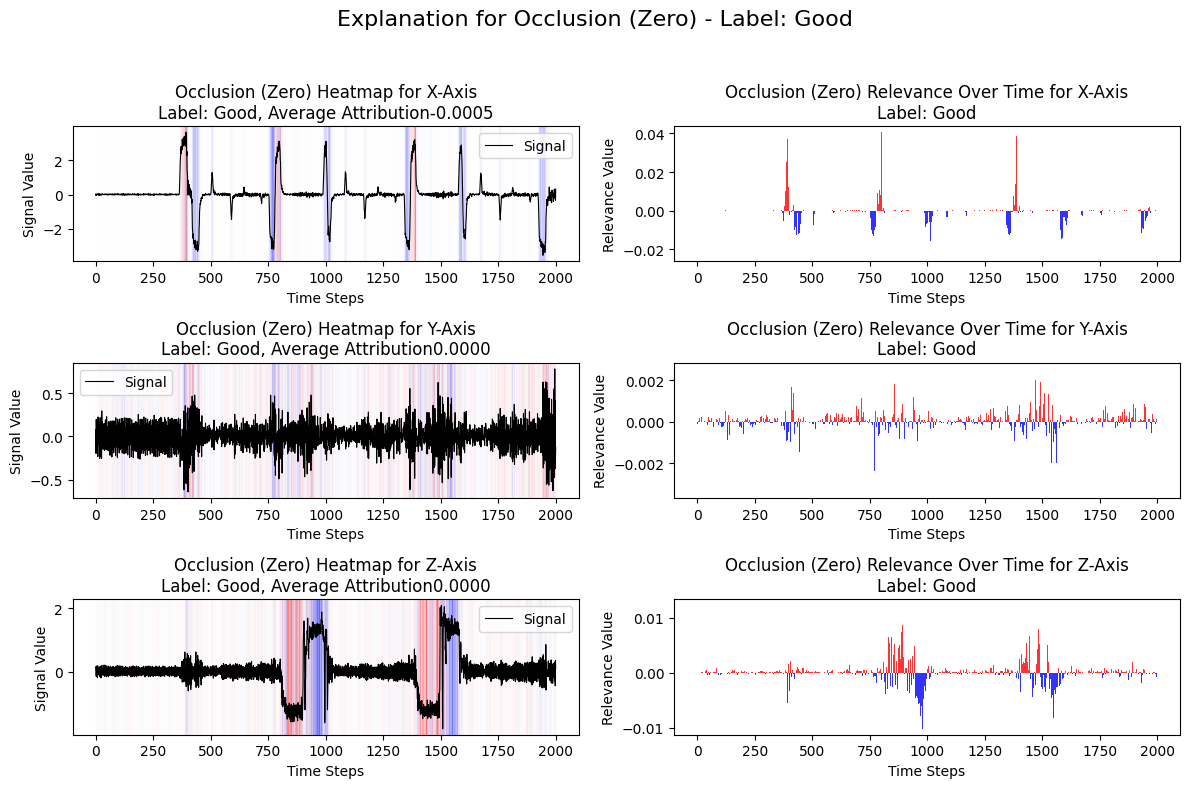

In [18]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.08160829544067383, Max relevance: 0.056778907775878906
 Maximum Absolute Attribution in Axis 0: 0.08160829544067383
 Maximum Absolute Attribution in Axis 1: 0.08160829544067383
 Maximum Absolute Attribution in Axis 2: 0.08160829544067383


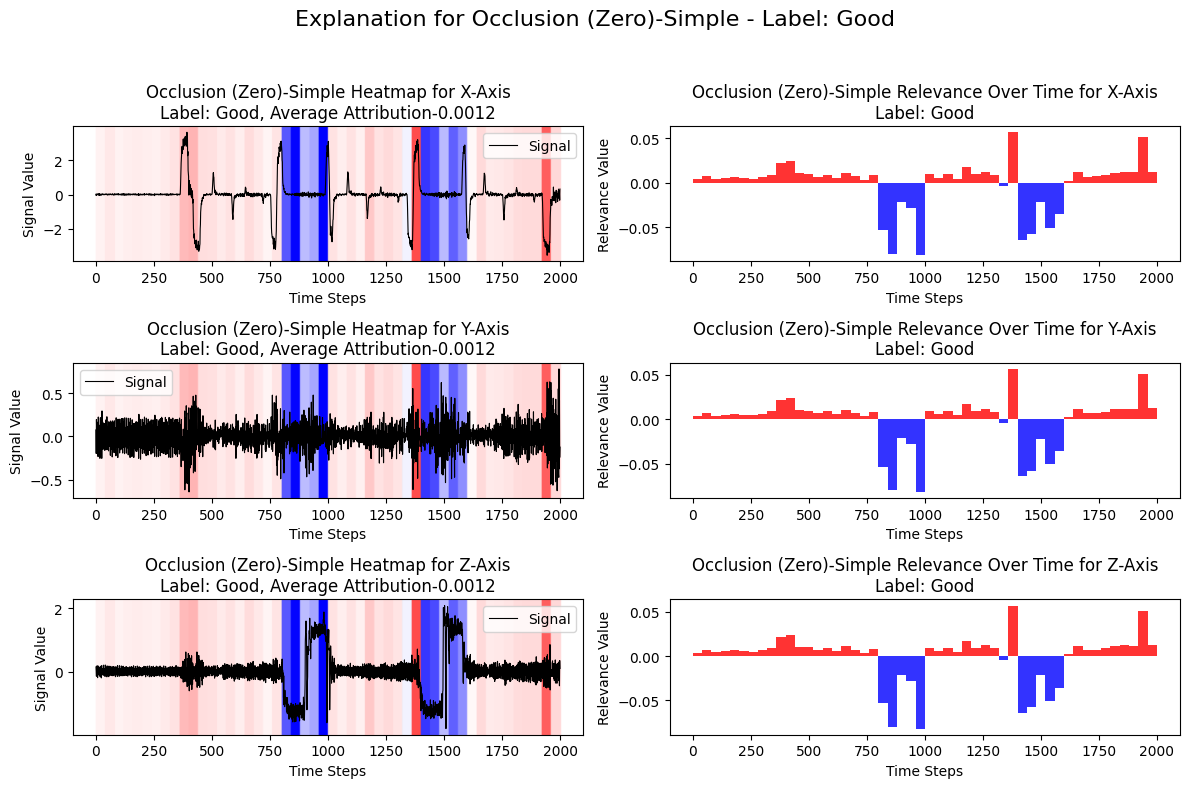

In [19]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(freq_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.06727457046508789, Max relevance: 0.10049724578857422
 Maximum Absolute Attribution in Axis 0: 0.10049724578857422
 Maximum Absolute Attribution in Axis 1: 0.10049724578857422
 Maximum Absolute Attribution in Axis 2: 0.10049724578857422


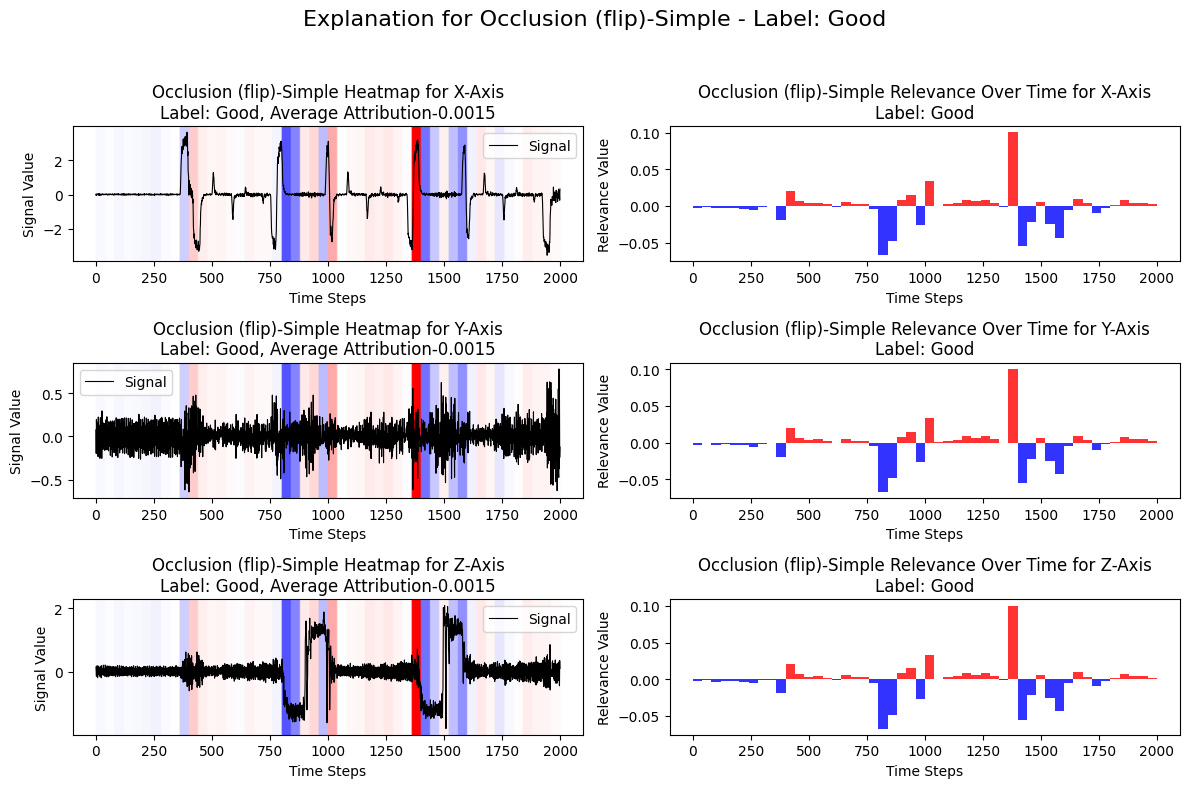

In [20]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(freq_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.02568960189819336, Max relevance: 0.029783248901367188
 Maximum Absolute Attribution in Axis 0: 0.029783248901367188
 Maximum Absolute Attribution in Axis 1: 0.00953817367553711
 Maximum Absolute Attribution in Axis 2: 0.022401809692382812


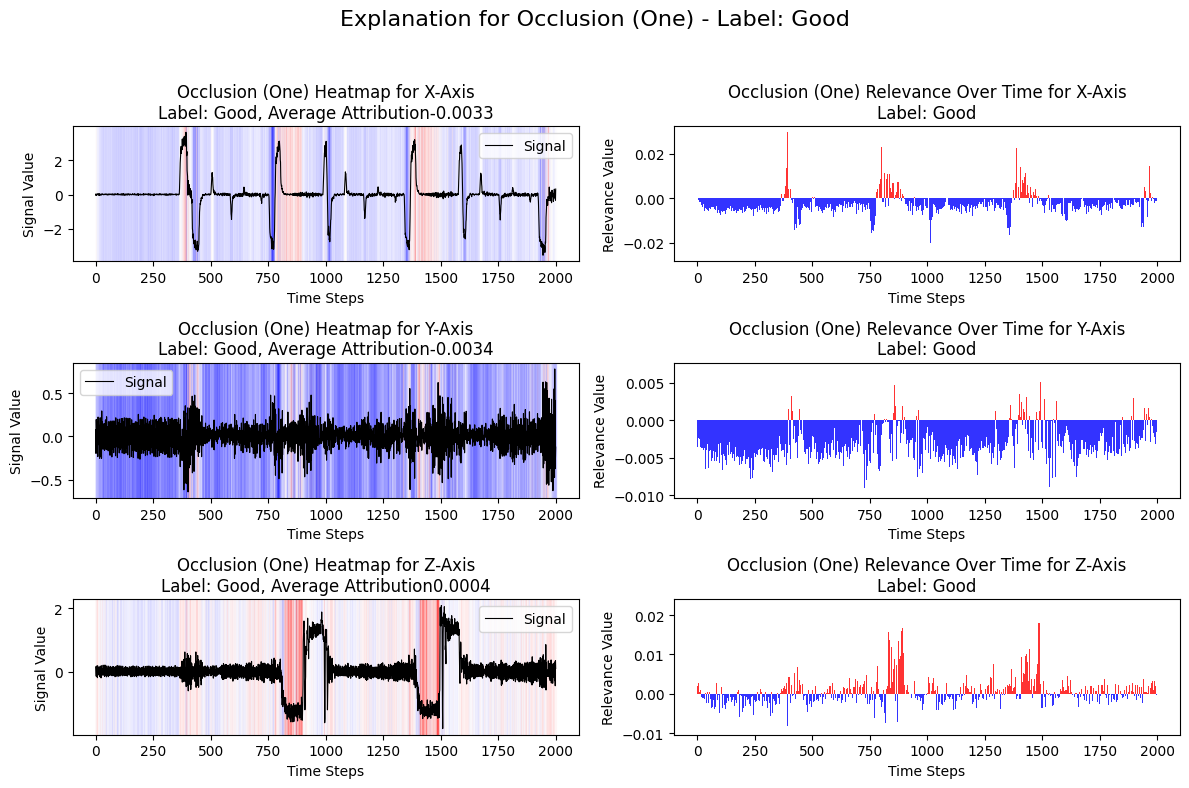

In [21]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.021261215209960938, Max relevance: 0.04749107360839844
 Maximum Absolute Attribution in Axis 0: 0.04749107360839844
 Maximum Absolute Attribution in Axis 1: 0.014256477355957031
 Maximum Absolute Attribution in Axis 2: 0.033832550048828125


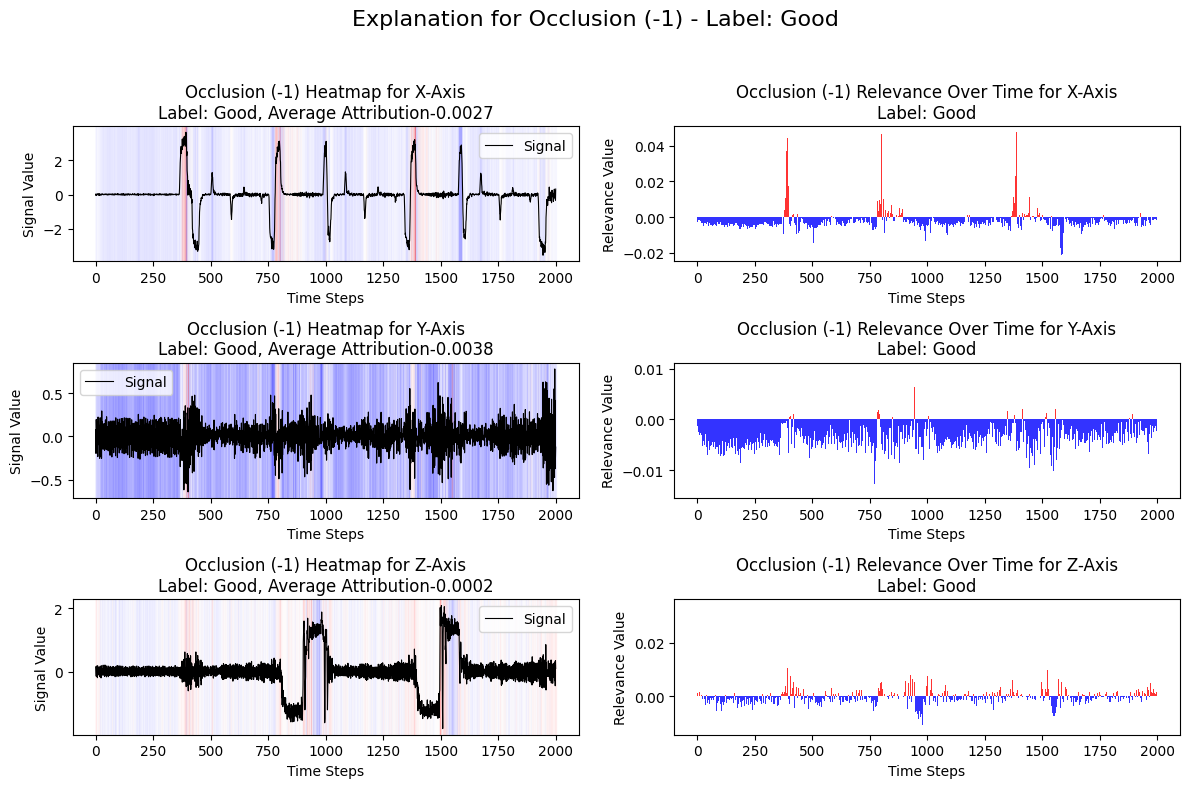

In [22]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.02810955047607422, Max relevance: 0.07324695587158203
 Maximum Absolute Attribution in Axis 0: 0.07324695587158203
 Maximum Absolute Attribution in Axis 1: 0.008380413055419922
 Maximum Absolute Attribution in Axis 2: 0.0374445915222168


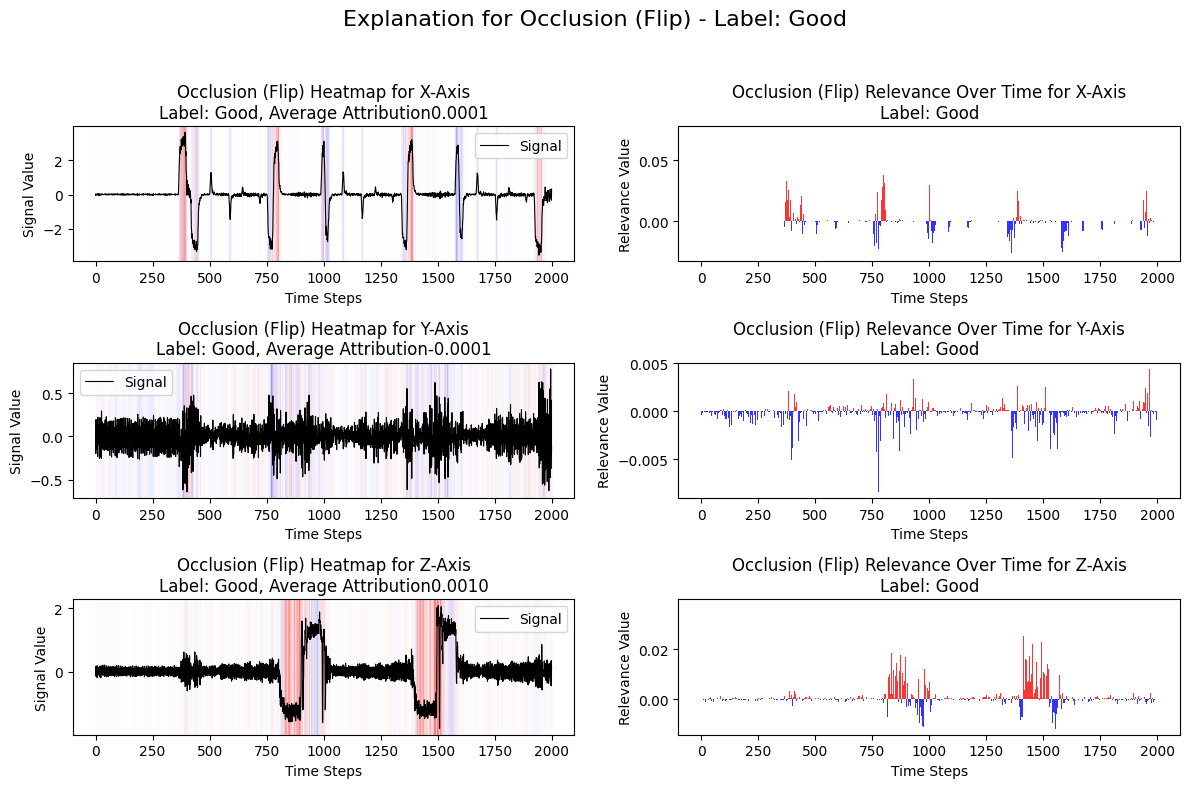

In [23]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


In [43]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(freq_model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}, True_label:{label_b}")
print(sample_b,sample_b.shape)


Random Index: 73, Predicted_label:1, True_label:1
tensor([[ 2.5935,  3.0486,  2.7104,  ..., -3.1941, -2.9636, -2.9134],
        [-0.8119, -0.2722, -0.5014,  ..., -0.1190,  0.8483, -0.0553],
        [ 1.1295, -1.6023,  0.6730,  ...,  1.6465, -2.2225,  0.3666]],
       device='cuda:0') torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 44 Label: Bad


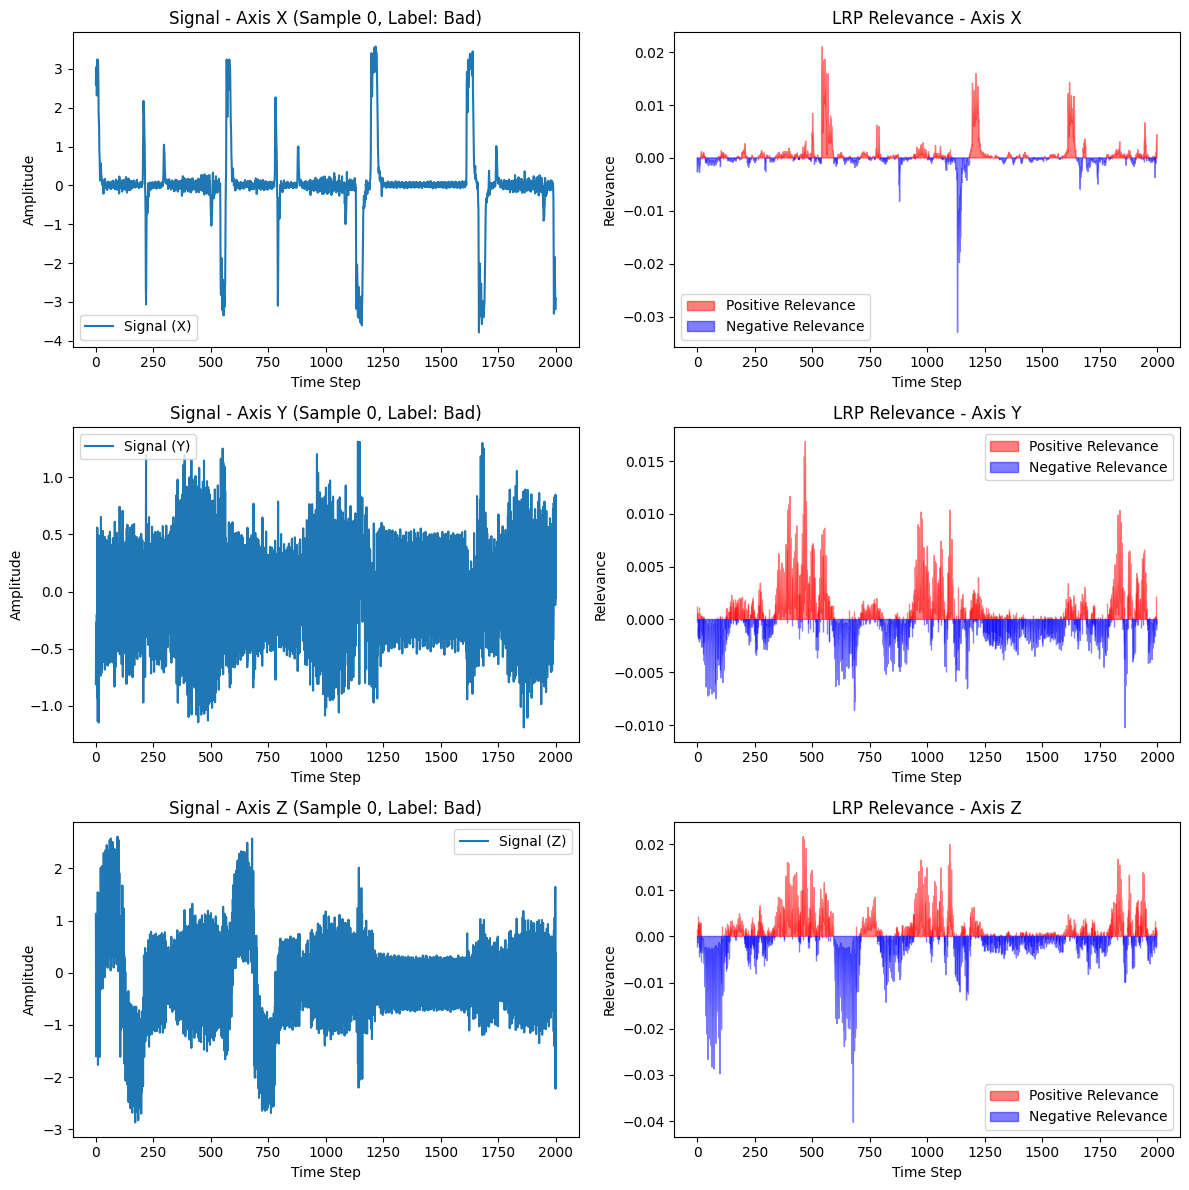

In [44]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=freq_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.04738827794790268, Max relevance: 0.04284512624144554
 Maximum Absolute Attribution in Axis 0: 0.04738827794790268
 Maximum Absolute Attribution in Axis 1: 0.0184071883559227
 Maximum Absolute Attribution in Axis 2: 0.04664080962538719


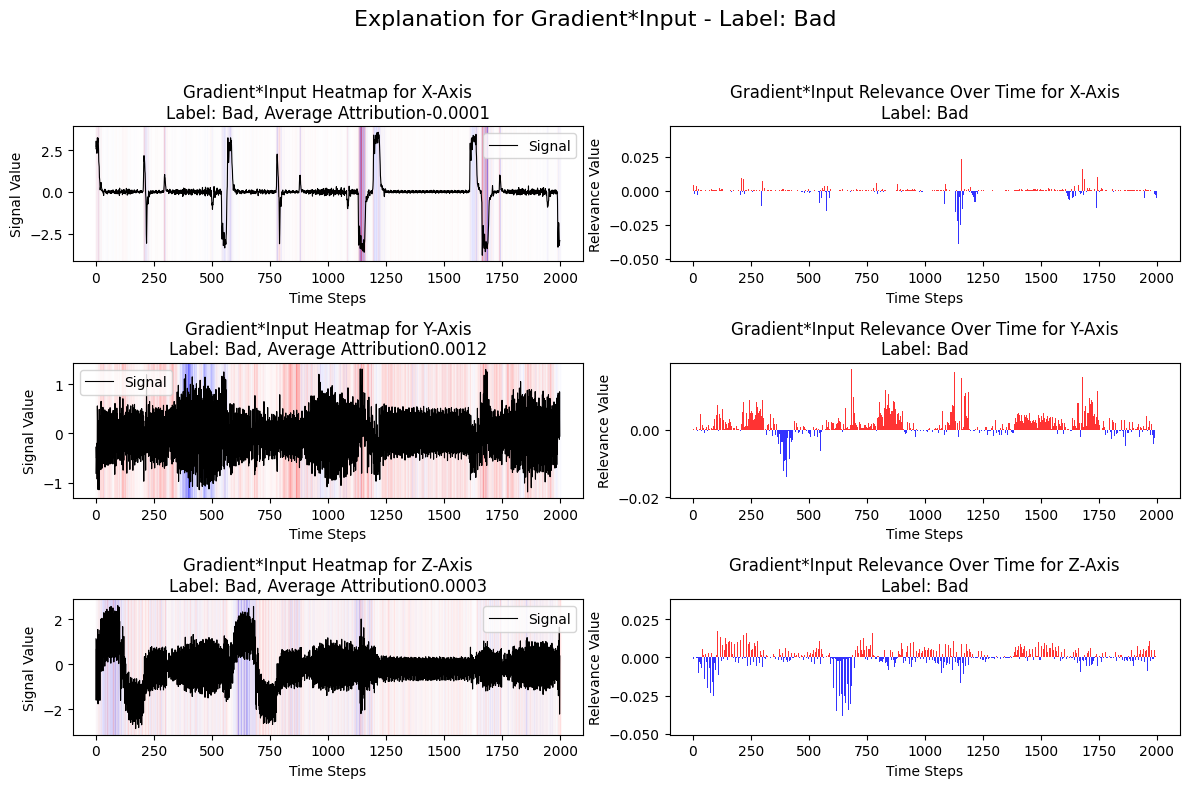

In [45]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(freq_model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [46]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1119                  1.234198   
1  Axis 1            1350                  3.362906   
2  Axis 2            1096                  3.987726   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001103             881                 -1.496491   
1                    0.002491             650                 -0.980465   
2                    0.003638             904                 -3.305253   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001699                    -0.262294   
1                   -0.001508                     2.382441   
2                   -0.003656                     0.682473   

   Average Relevance (Pos + Neg)  
0                      -0.000131  
1                       0.001191  
2                       0.000341  


Min relevance: -0.01628248207271099, Max relevance: 0.013527107425034046
 Maximum Absolute Attribution in Axis 0: 0.01264229416847229
 Maximum Absolute Attribution in Axis 1: 0.006518776062875986
 Maximum Absolute Attribution in Axis 2: 0.01628248207271099


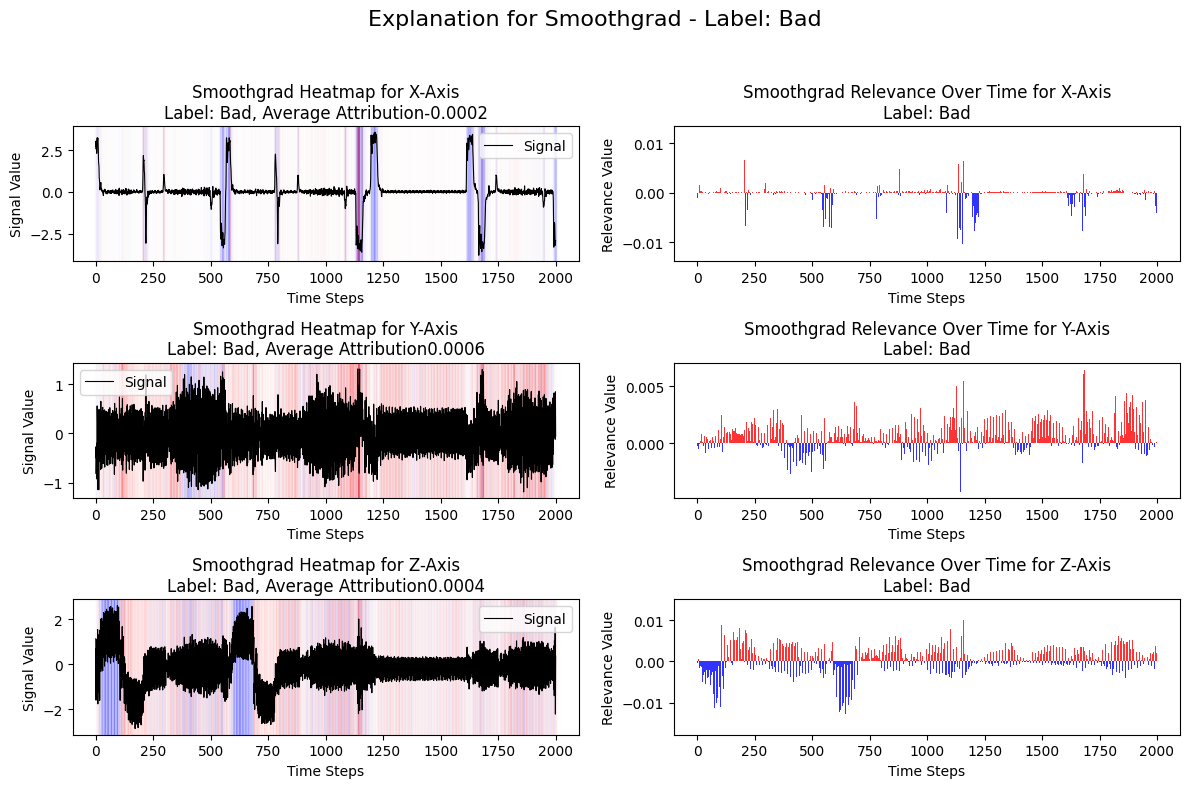

In [47]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(freq_model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [48]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1115                  0.371681   
1  Axis 1            1388                  1.609340   
2  Axis 2            1030                  2.750118   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000333             885                 -0.777341   
1                    0.001159             612                 -0.356394   
2                    0.002670             970                 -2.020968   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000878                    -0.405660   
1                   -0.000582                     1.252946   
2                   -0.002083                     0.729149   

   Average Relevance (Pos + Neg)  
0                      -0.000203  
1                       0.000626  
2                       0.000365  


Min relevance: -0.04153013229370117, Max relevance: 0.025276660919189453
 Maximum Absolute Attribution in Axis 0: 0.03219127655029297
 Maximum Absolute Attribution in Axis 1: 0.017336368560791016
 Maximum Absolute Attribution in Axis 2: 0.04153013229370117


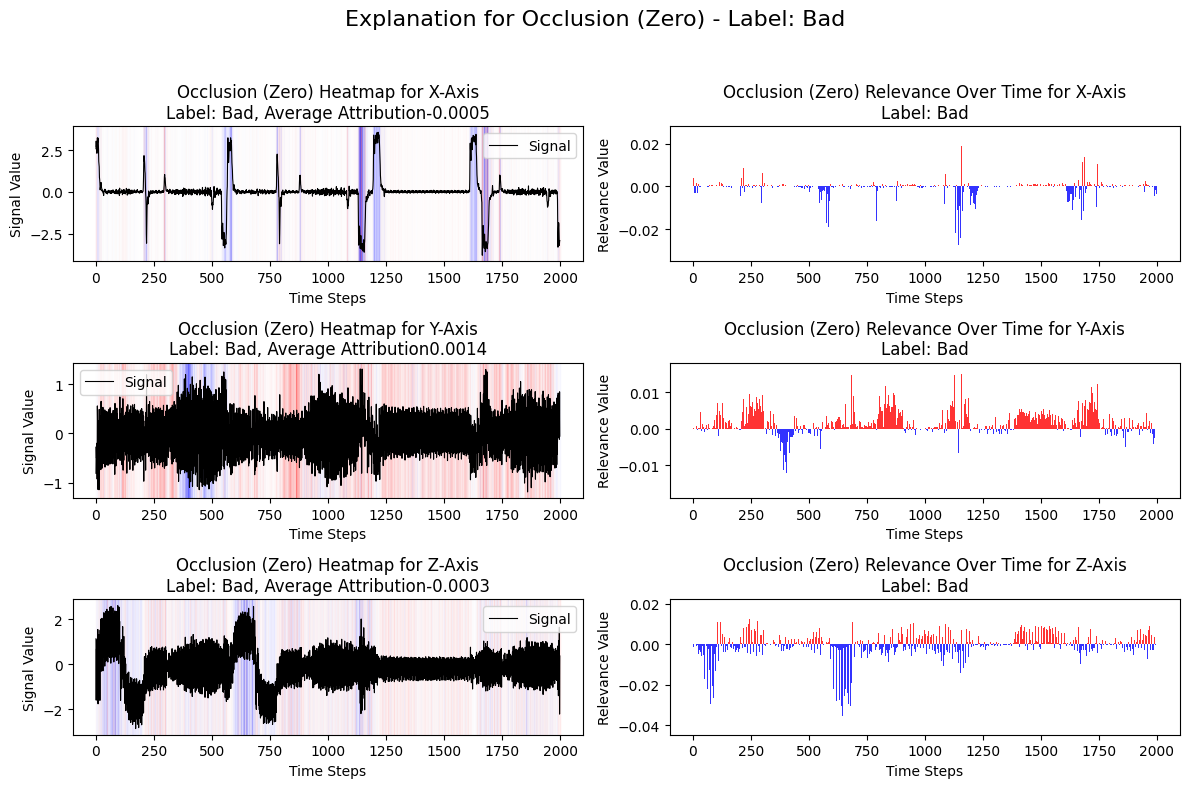

In [49]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.043965816497802734, Max relevance: 0.03657960891723633
 Maximum Absolute Attribution in Axis 0: 0.043965816497802734
 Maximum Absolute Attribution in Axis 1: 0.03657960891723633
 Maximum Absolute Attribution in Axis 2: 0.02935647964477539


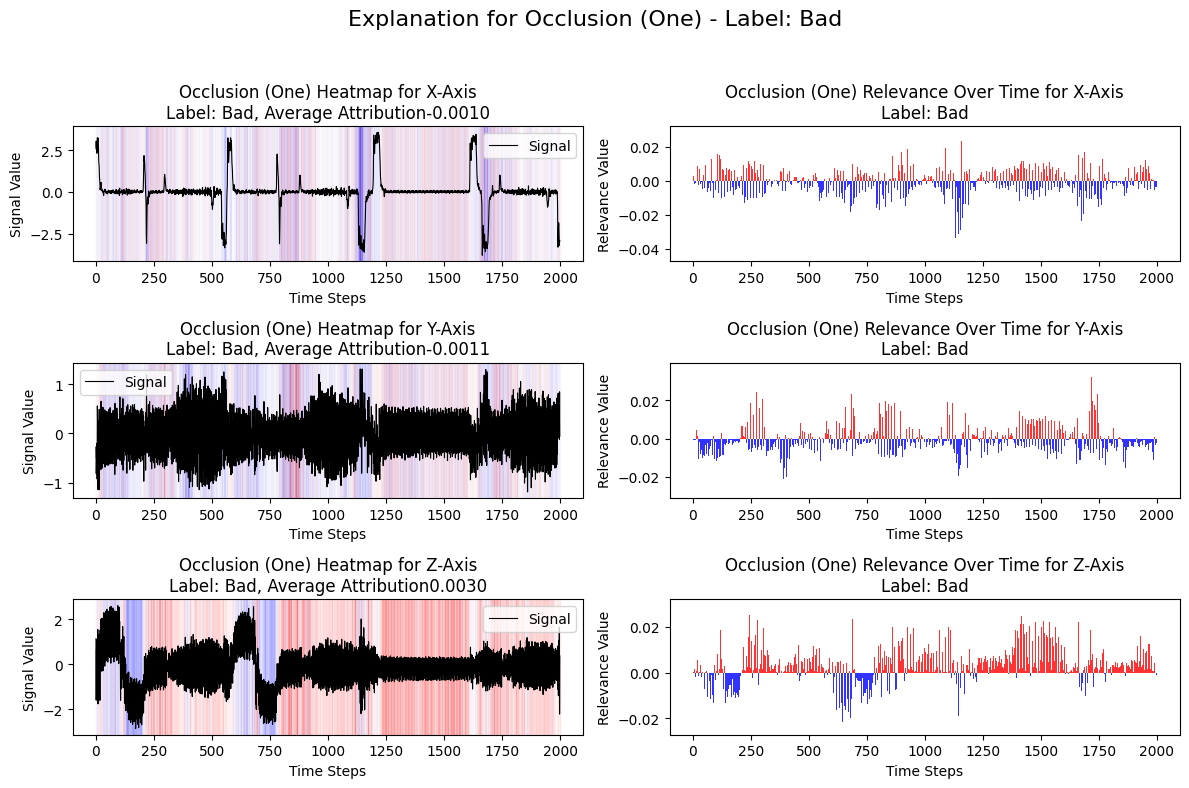

In [50]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.05446910858154297, Max relevance: 0.034802913665771484
 Maximum Absolute Attribution in Axis 0: 0.03230142593383789
 Maximum Absolute Attribution in Axis 1: 0.034802913665771484
 Maximum Absolute Attribution in Axis 2: 0.05446910858154297


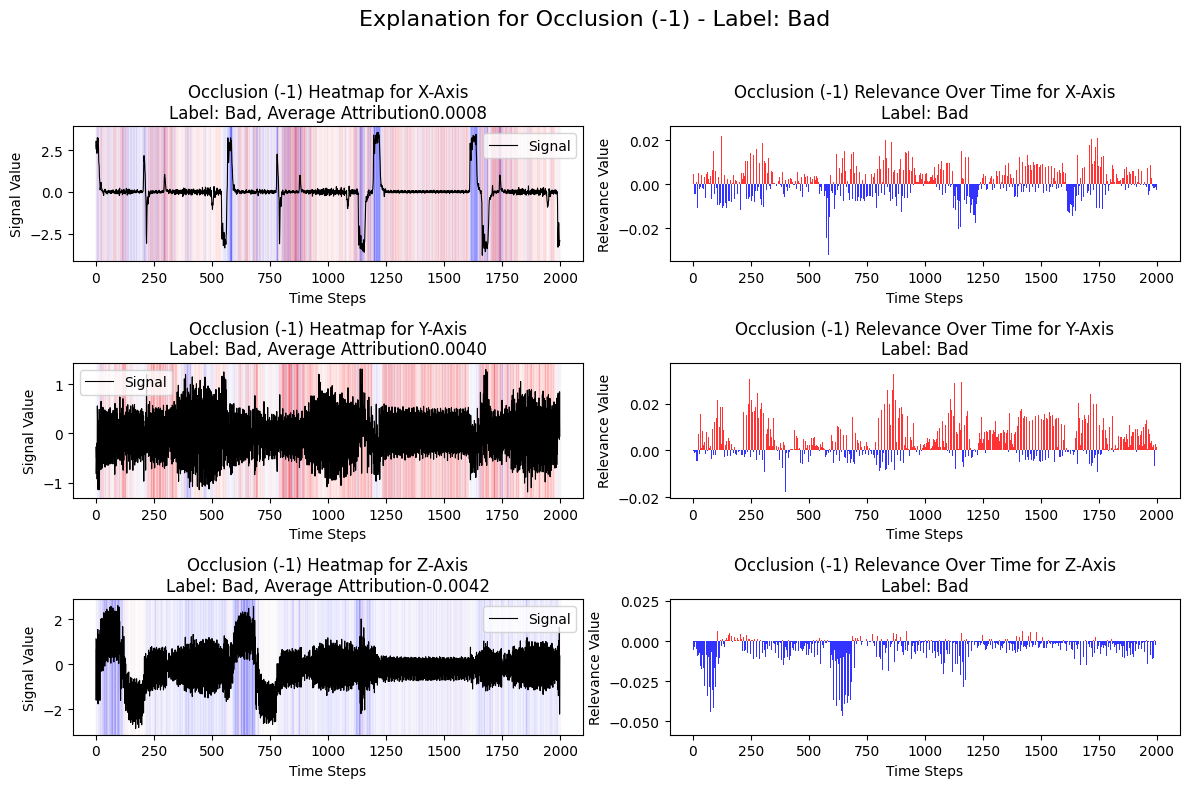

In [51]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.07171392440795898, Max relevance: 0.03595161437988281
 Maximum Absolute Attribution in Axis 0: 0.058512210845947266
 Maximum Absolute Attribution in Axis 1: 0.031158447265625
 Maximum Absolute Attribution in Axis 2: 0.07171392440795898


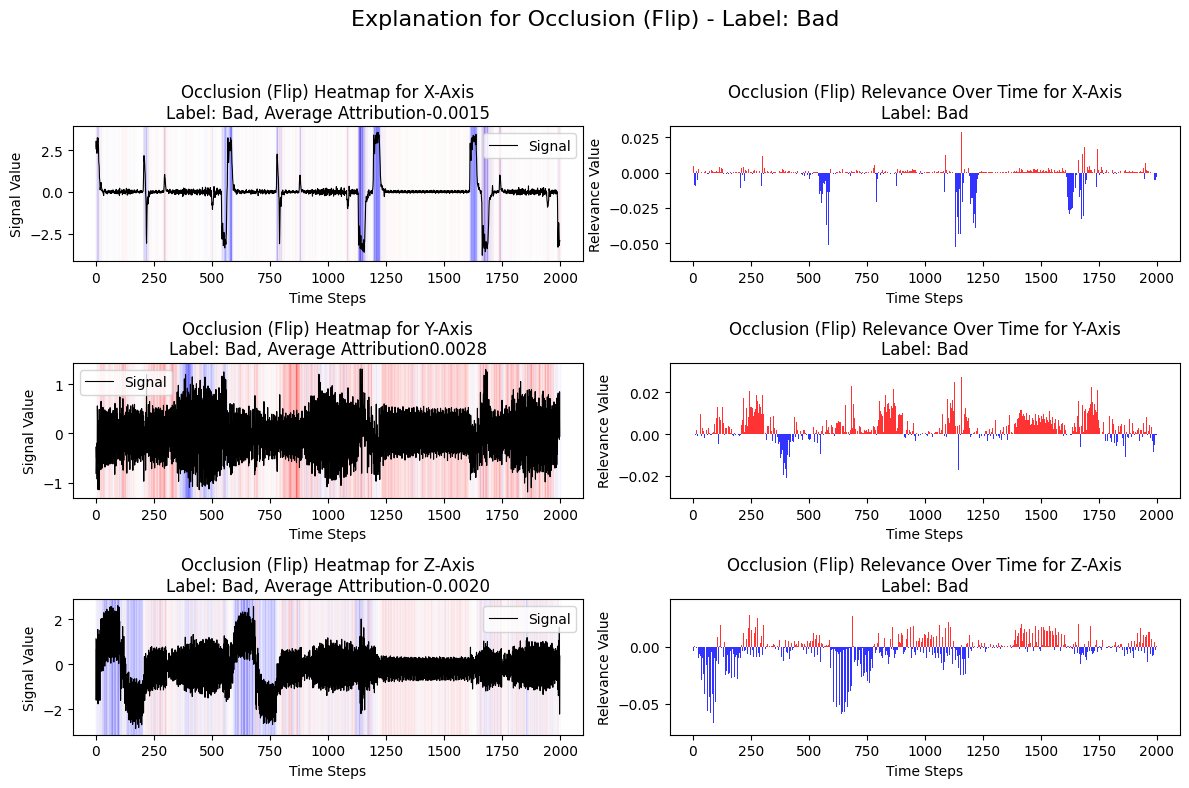

In [52]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


Min relevance: -0.0402759425342083, Max relevance: 0.021608173847198486
 Maximum Absolute Attribution in Axis 0: 0.03300577774643898
 Maximum Absolute Attribution in Axis 1: 0.01684277504682541
 Maximum Absolute Attribution in Axis 2: 0.0402759425342083


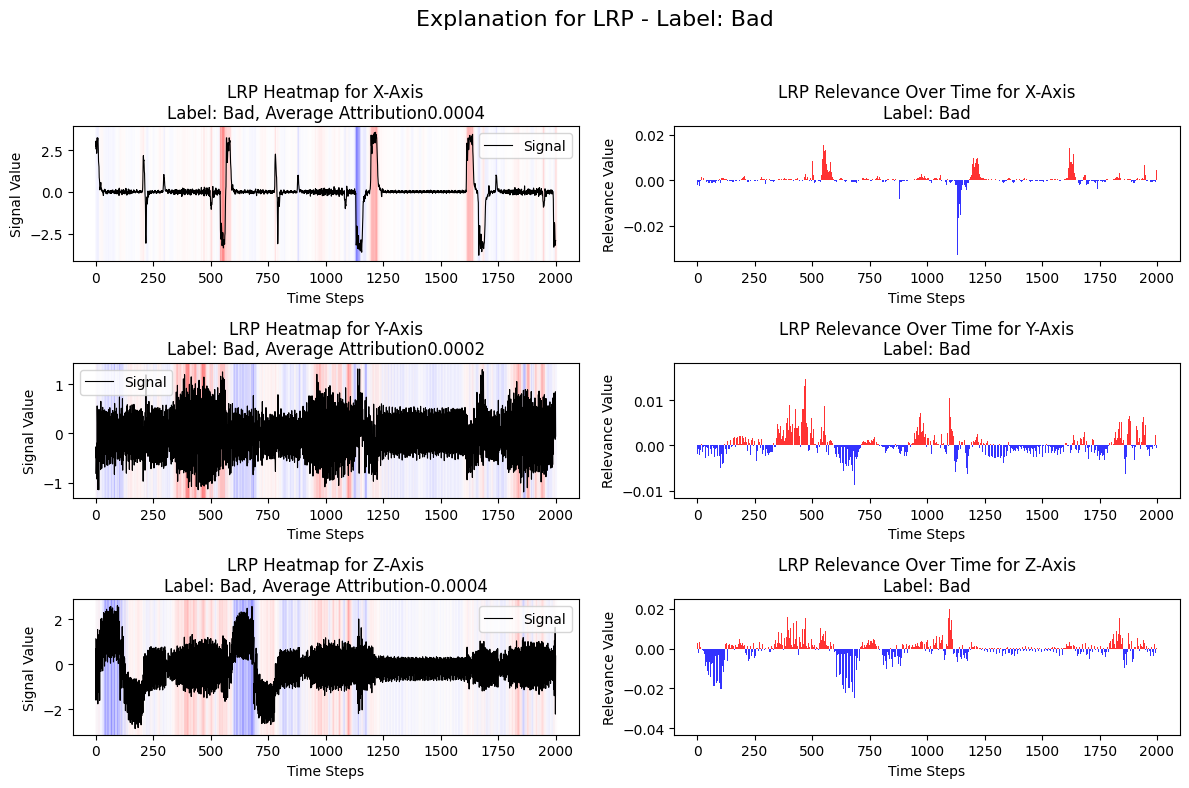

In [53]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [54]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1081                  1.404962   
1  Axis 1            1394                  7.311479   
2  Axis 2             901                  5.434550   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001300             919                 -4.478204   
1                    0.005245             606                 -1.673773   
2                    0.006032            1099                 -9.387781   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.004873                    -3.073242   
1                   -0.002762                     5.637706   
2                   -0.008542                    -3.953231   

   Average Relevance (Pos + Neg)  
0                      -0.001537  
1                       0.002819  
2                      -0.001977  


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 73 Label: Bad


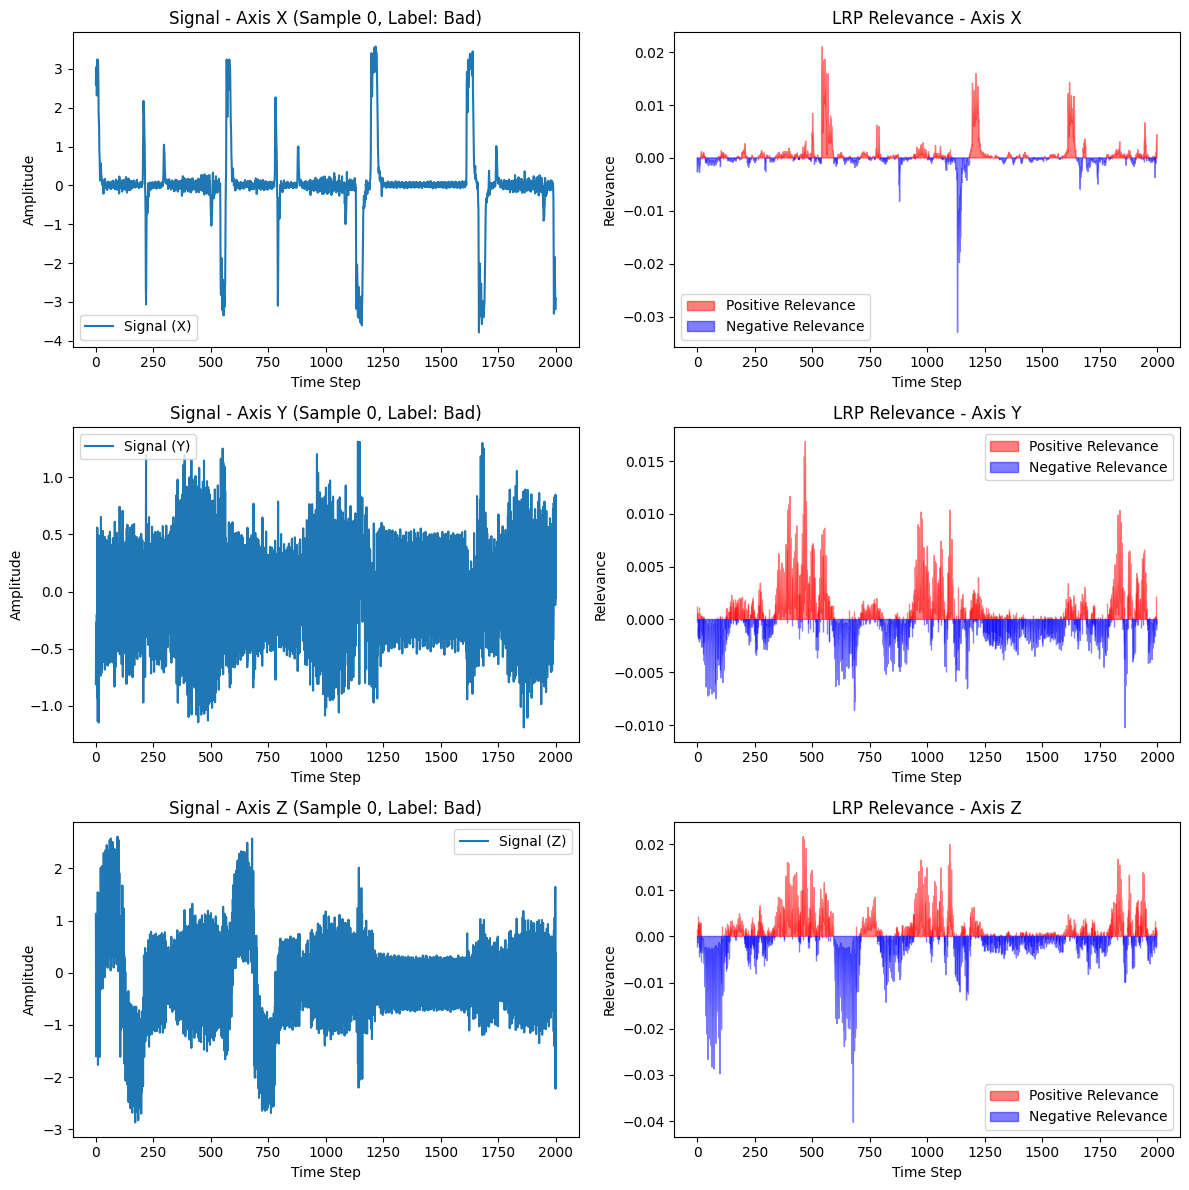

In [55]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=freq_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index_b} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.0402759425342083, Max relevance: 0.021608173847198486
 Maximum Absolute Attribution in Axis 0: 0.03300577774643898
 Maximum Absolute Attribution in Axis 1: 0.016842776909470558
 Maximum Absolute Attribution in Axis 2: 0.0402759425342083


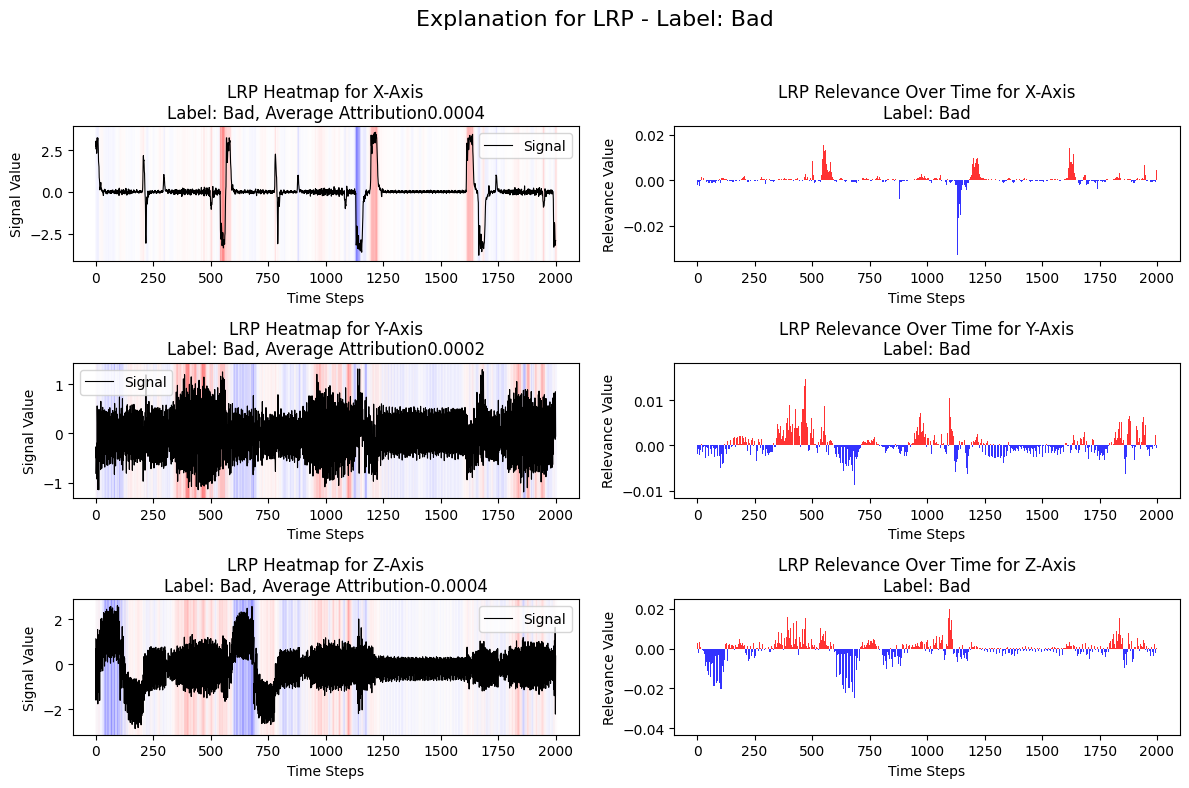

In [56]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [57]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=freq_model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


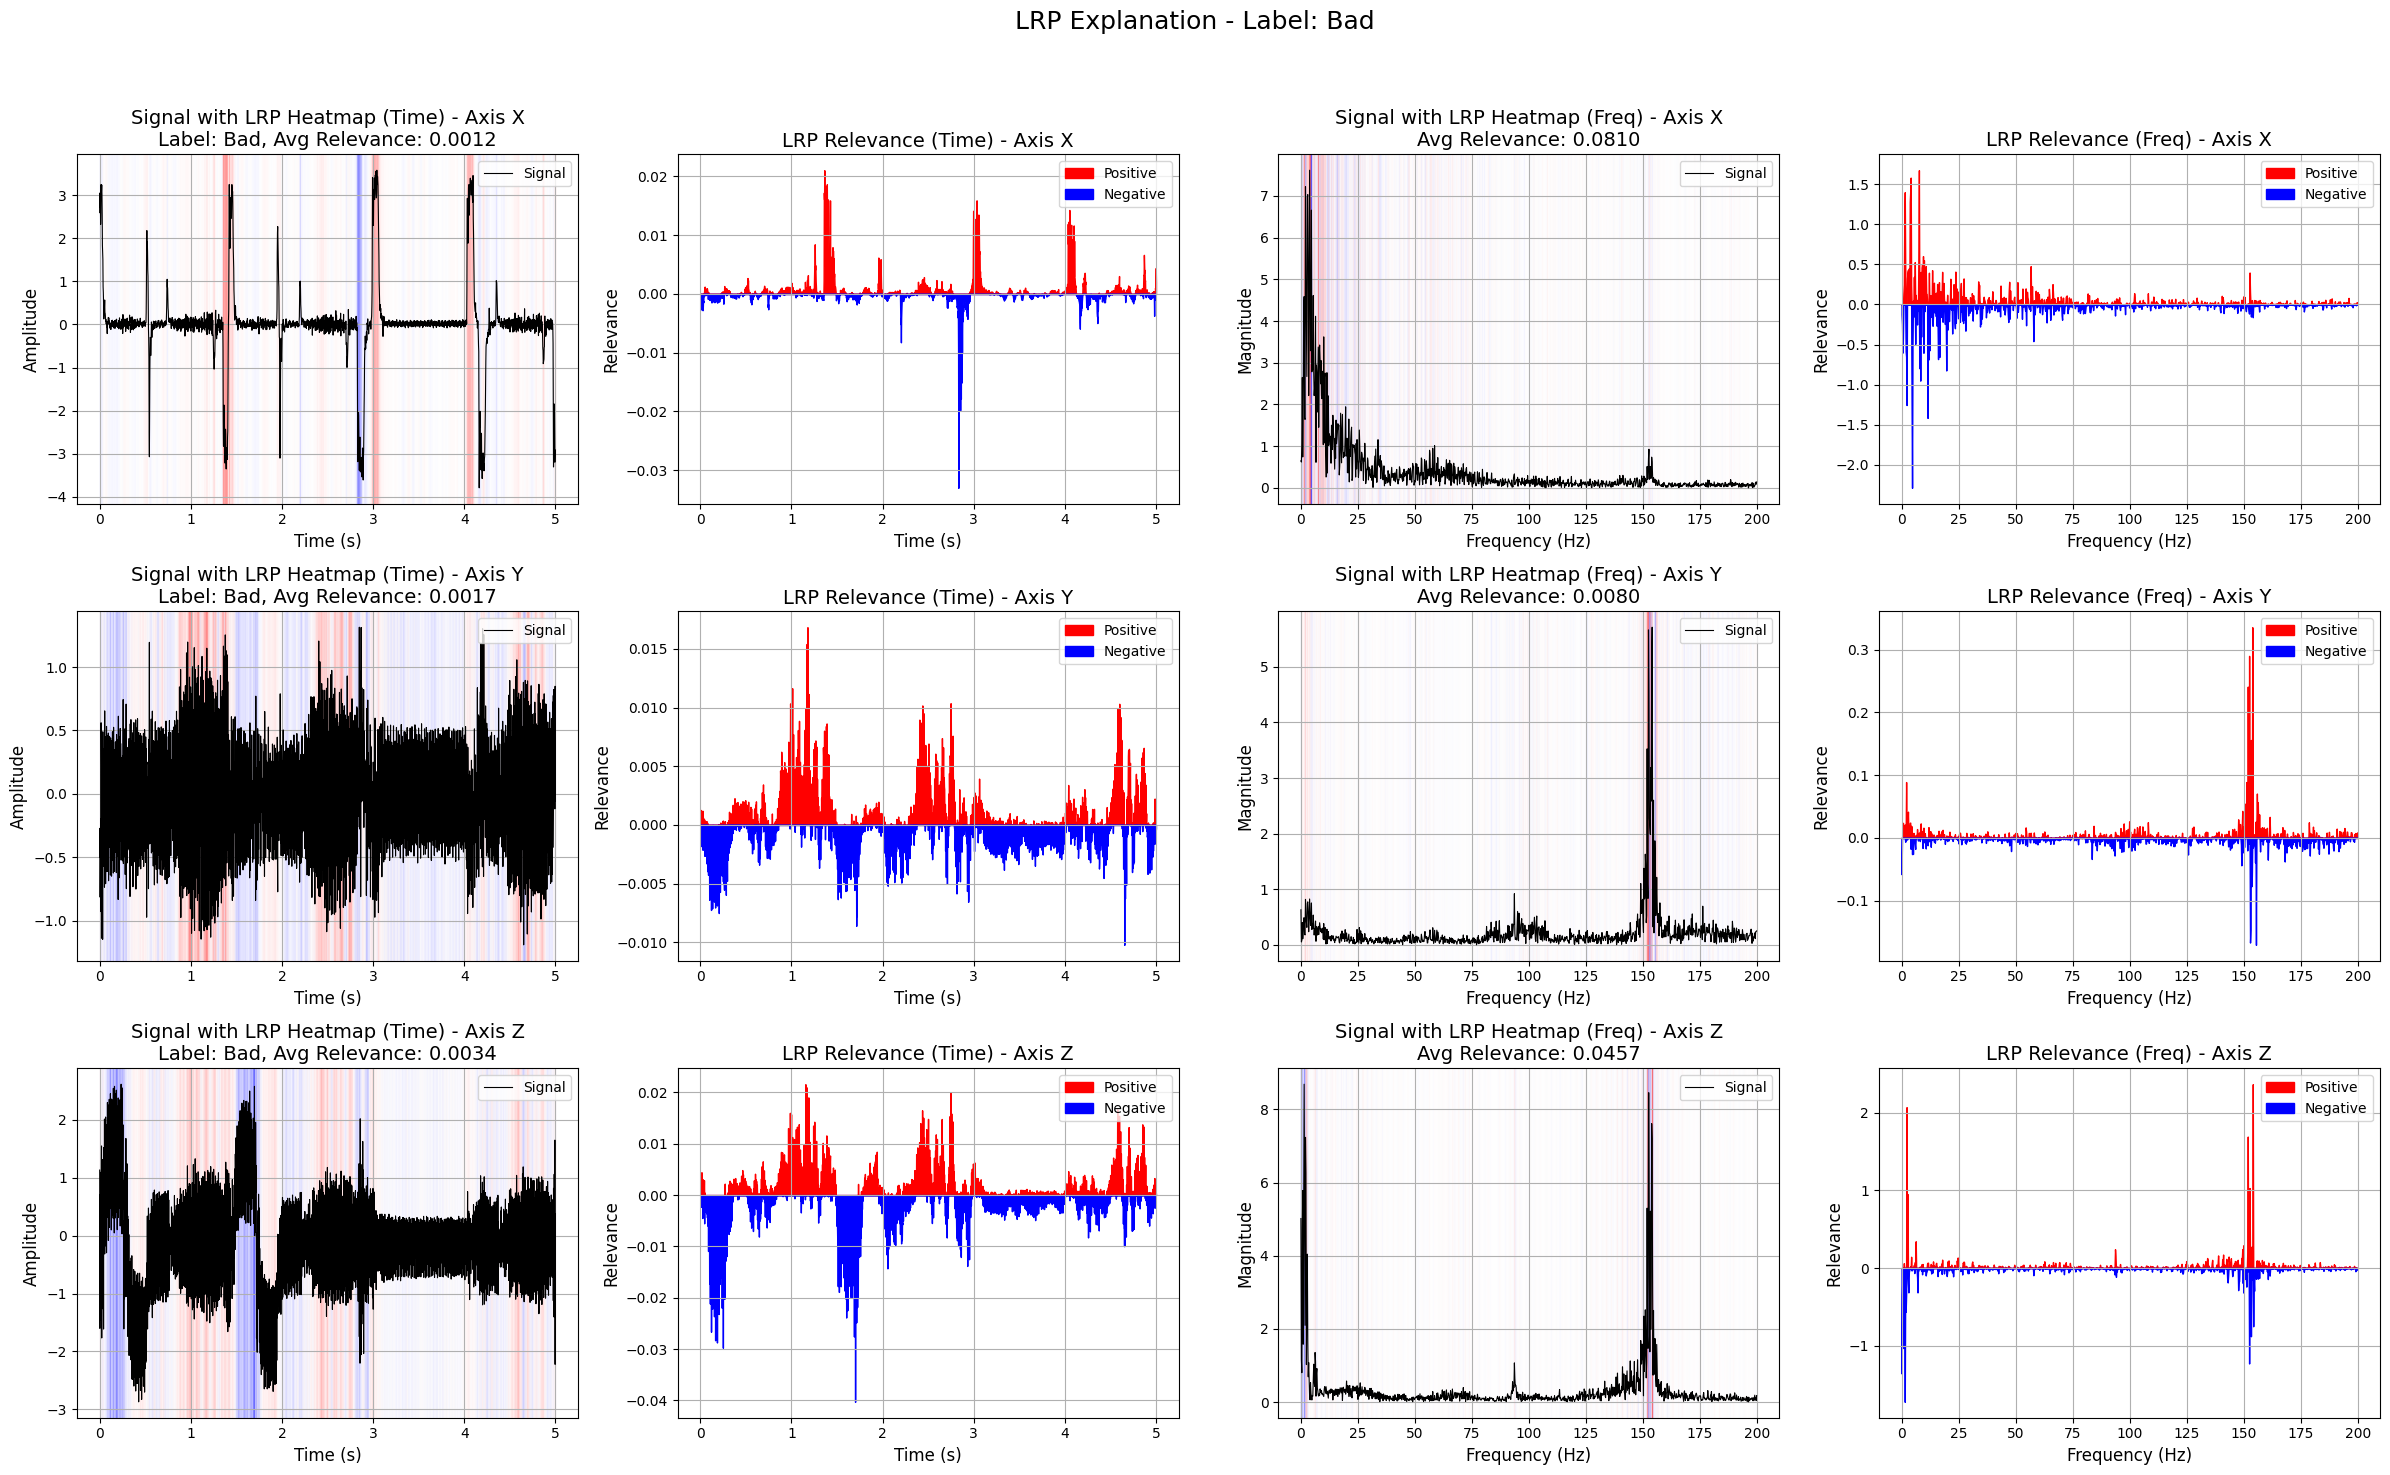

In [58]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [59]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             502                 40.929703   
1  Axis 1             461                  4.193664   
2  Axis 2             507                 22.514266   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.081533             499                -40.165483   
1                    0.009097             540                 -3.804475   
2                    0.044407             494                -23.262620   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.080492                     0.764220   
1                   -0.007045                     0.389189   
2                   -0.047090                    -0.748353   

   Average Relevance (Pos + Neg)  
0                       0.000763  
1                       0.000389  
2                      -0.000748  


In [60]:
""# Global Attribution over frequency with LRP
summary_lrp_t_b = summarize_attributions(relevance_time_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t_b = []
for axis, values in summary_lrp_t_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t_b.append(row)

# Create the DataFrame
df_summary_lrp_t_b = pd.DataFrame(data_lrp_t_b)

# Display the DataFrame as a table
print(df_summary_lrp_t_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1104                  1.591559   
1  Axis 1             972                  1.926933   
2  Axis 2            1052                  2.997466   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001442             896                 -0.832850   
1                    0.001982            1028                 -1.531722   
2                    0.002849             948                 -3.714183   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000930                     0.758710   
1                   -0.001490                     0.395212   
2                   -0.003918                    -0.716717   

   Average Relevance (Pos + Neg)  
0                       0.000379  
1                       0.000198  
2                      -0.000358  
